In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random
import treeswift
from treeswift import Tree, Node
import argparse
import csv
#import UltrametricConversion
from UltrametricConversion import traverse_and_run_average
from UltrametricConversion import transform_data
from UltrametricConversion import normalise_data
# create an argparse parser
# parser = argparse.ArgumentParser(description="Simulate population and tree")

# # add arguments for the simulation parameters
# parser.add_argument("--N", type=int, help="population size")
# parser.add_argument("--generations", type=int, help="number of generations to simulate")
# parser.add_argument("--disease", type=int, help="number of generations the disease starts")
# parser.add_argument("--mut_samples", type=int, help="number of mutation samples")
# parser.add_argument("--s", type=float, help="selection coefficient")
# parser.add_argument("--mu", type=float, help="mutation rate")
# parser.add_argument("--sim_number", type=float, help="The number of simulations to run")
# parser.add_argument('--output_path', type=str, default='.', help='output path')


# # parse the command-line arguments
# args = parser.parse_args()

class Population:
    def __init__(self, N, generations, disease, s):
        self.N = N
        self.s = s
        self.generations = generations
        self.disease = disease
        self.generation_data = []

    def __str__(self):
        return f"Population size: {self.N}, Generations: {self.generations}, Disease_Onset: {self.disease}, Selection: {self.s}"

    def simulate_population(self):
        """
        Simulate the population using the Wright-Fisher model with selection.
        """

        # Initialize the first population
        population = np.zeros(self.N, dtype=int)
        self.generation_data.append(population)
        binom_prob_list  = []
        mut_n_list = []

        for gen in range(1,self.generations+1):
            print(gen)
            if gen-1 < len(self.generation_data) and len(self.generation_data) > 0:
                print("Passed if")
                if gen < self.disease:
                    print("Disease hasn't started yet")
                    self.generation_data.append(np.zeros(self.N, dtype=int))
                    mut_n_list.append(0)
                    binom_prob_list.append(0)
                elif gen == self.disease:
                    # first cell with mutation
                    print("Disease started")
                    population[random.randint(0, self.N - 1)] = 1
                    self.generation_data.append(population)
                elif gen > self.disease:
                    # clonal expansion
                    print("Expansion started")
                    print(f"Length self.gen.data: {len(self.generation_data)}")
                    print(self.generation_data[gen-1])
                    mut_n = len(np.where(self.generation_data[gen-1] == 1)[0])
                    print(mut_n)
                    mut_n_list.append(mut_n)
                        
                    cancer_p = (1 + self.s) * mut_n / (self.N + (mut_n * self.s))
                    binom_prob_list.append(cancer_p)
                            
                    offspring = np.random.binomial(n=1, p=cancer_p, size=self.N)
                    
                    self.generation_data.append(offspring)

                    num_mutants = [np.count_nonzero(offspring == 1)]                    
                    if num_mutants == 0:
                        print("Stochastic Extinction")
        # for gen in range(self.generations):
        #     mut_n = len(np.where(self.generation_data[gen] == 1)[0])
        #     mut_n_list.append(mut_n)
            
        #     cancer_p = (1 + self.s) * mut_n / (self.N + (mut_n * self.s))
        #     binom_prob_list.append(cancer_p)
                
        #     offspring = np.random.binomial(n=1, p=cancer_p, size=self.N)
            
        #     num_mutants = [np.count_nonzero(offspring == 1)]
            
        #     if num_mutants == 0:
        #         print("Stochastic Extinction")
        #         self.generation_data.append(offspring)
        #         num_mutants = [np.count_nonzero(generation == 1) for generation in self.generation_data]
        #         # Plot the number of mutants over time
        #         fig, ax = plt.subplots()
        #         ax.plot(range(len(num_mutants)), np.log(num_mutants))
        #         ax.set_xlabel("Time in Generations")
        #         ax.set_ylabel("Number of mutants ln(N)")
        #         ax.set_title(f"Mutant allele frequency over time (s={self.s})")
        #         plt.show()
        #         return(self.generation_data, binom_prob_list, mut_n_list, fig) 
            
        #     self.generation_data.append(offspring)
            
        # Plot the number of mutants over time
        # Count the number of individuals with a value of 1 in each generation
        num_mutants = [np.count_nonzero(generation == 1) for generation in self.generation_data]
        
        # Plot the number of mutants over time
        fig, ax = plt.subplots()
        ax.plot(range(len(num_mutants)), np.log(num_mutants))
        ax.set_xlabel("Time in Generations")
        ax.set_ylabel("Number of mutants ln(N)")
        ax.set_title(f"Mutant allele frequency over time (s={self.s})")
        plt.show()
        
        return(self.generation_data, binom_prob_list, mut_n_list, fig) 
    

def build_leaf_to_root_connections(tree_mask, mut_samples):
    """
    Simulate the population using the Wright-Fisher model with selection.
    """
    # List of each generation, where each generation is a dict from node_idx to set of leaves
    node_to_leaves = []
    desired_number = mut_samples

    # Initialize the list of generations
    for generation_idx, generation in enumerate(tree_mask):
        node_to_leaves.append({})
        for node_idx, node in enumerate(generation):
            if node == 1:
                node_to_leaves[-1][node_idx] = set()

    assert desired_number <= len(node_to_leaves[-1])
    node_to_leaves[-1] = {
        id: set() 
        for id in np.random.choice(
            list(node_to_leaves[-1].keys()), 
            desired_number, 
            replace=False
        )
    }

    # Go backward from leaf to root, randomly assigning each leaf to a parent
    for leaf_idx in node_to_leaves[-1].keys():
        leaf_to_follow = None
        for generation_idx, generation in reversed(
            list(enumerate(node_to_leaves[:-1]))
        ):
             if not generation:  # Skip if the generation has no nodes
                continue
            # If we already have a leaf to follow, pick it's ancestor, otherwise pick a random one
            if leaf_to_follow is not None:
                parent_idx = next(
                    node
                    for node, leaves in generation.items()
                    if leaf_to_follow in leaves
                )
            else:
                parent_idx = random.choice(list(generation.keys()))
            
            
            # If the parent already has a leaf, pick it's ancestor in all previous generations to avoid cycles
            if len(node_to_leaves[generation_idx][parent_idx]) > 0:
                leaf_to_follow = list(node_to_leaves[generation_idx][parent_idx])[0]

            # Add the leaf to the parent
            node_to_leaves[generation_idx][parent_idx].add(
                (len(node_to_leaves) - 1, leaf_idx)
            )

    # Drop any non leaves that weren't connected
    # Create a dict from node coordinates to leaf coordinates
    result = {}
    
    for generation_idx, generation in enumerate(node_to_leaves):
        for node_idx, leaves in generation.items():
            if generation_idx == len(node_to_leaves) - 1 or len(leaves) > 0:
                result[str((generation_idx, node_idx))] = {str(leaf) for leaf in leaves}

    return result

def clusters_to_nodes(tree_clusters):
    """
    the following function goes from a nested dictionary of clades, creates the root node, adds node to that root 
    and then establishes parent and children relationships    """
    
    label_to_node = {cluster: Node(label=cluster) for cluster in tree_clusters}
    root_name = list(tree_clusters.keys())[0]
    
    # Connect each node with it's leaves 
    for parent_label, leaf_labels in tree_clusters.items():
        parent_node = label_to_node[parent_label]
        for leaf_label in leaf_labels:
            leaf_node = label_to_node[leaf_label]
            parent_node.add_child(leaf_node)

    # Connect each node with all descendants
    for node1 in label_to_node.values():
        for node2 in label_to_node.values():
            if node1 == node2:
                continue

            node_1_gen = int(node1.label.split(',')[0][1:]) # split the key on comma, take the first element, and remove the opening parenthesis
            node_2_gen = int(node2.label.split(',')[0][1:]) # split the key on comma, take the first element, and remove the opening parenthesis
            
            if abs(node_2_gen - node_1_gen) > 1 :
                continue
            
            possible_parent = node1 if len(node1.child_nodes()) > len(node2.child_nodes()) else node2
            possible_child = node2 if possible_parent is node1 else node1
            
            parent_leaf_labels = {node.label for node in possible_parent.child_nodes()}
            child_leaf_labels = {node.label for node in possible_child.child_nodes()}
            is_descendant = child_leaf_labels.issubset(parent_leaf_labels)

            if is_descendant and possible_child not in possible_parent.child_nodes() and possible_child.child_nodes():
                possible_parent.add_child(possible_child)

########  Remove non-direct descendants
    next_nodes = {label_to_node[root_name]}
    while next_nodes:
        node = next_nodes.pop()
        for child in node.child_nodes():
            next_nodes.add(child)
            child.set_parent(node)
            for grandchild in child.child_nodes():
                if grandchild in node.child_nodes():
                    node.remove_child(grandchild)

    # Create the tree using TreeSwift
    tree = Tree()
    tree.root = label_to_node[root_name]

    return tree

def assign_edge_lengths(mu, tree):
    """
    Iterate through the tree class and assign edge lengths based on a Poisson distribution with mean rate μ.
    """
    for node in tree.traverse_preorder():
        length = np.random.poisson(mu)
        node.set_edge_length(length)
    return tree

def read_observed_data(observed_data_path):
    """
    Read observed tree and calculate LTT statistics and return or read in LTT statistics straight
    """

    # Define the path to the file containing the tree
    tree_file = observed_data_path

    # Load the tree from the TSV file
    with open(tree_file) as f:
        tree_str = f.read()
    tree = treeswift.read_tree_newick(tree_str)
    
    # Calculate lineage through time plot statistics
    ltt = tree.lineages_through_time()

    # Save the results in a data structure
    results = {
        "tree": tree,
        "ltt": ltt,
    }
    print("Tree:", results["tree"])
    print("LTT statistics:", results["ltt"])
    return tree,ltt

##### ------------- Wright-Fisher Simulation ------------------------------ #

def simulate_population_and_tree(N, generations, disease, mut_samples, s, mu, output_path, num_retries):
    print("Simulating population...")
    # initiate population
    popul = Population(N, generations, disease, s) 
    # go from population array to tree_clusters dictionary
    gen, prob, mut, fig = popul.simulate_population()
    fig.savefig(f"{output_path}/Simulation_{num_retries}_with_mutants_in_time_(s={s}).png")
    print("Population Done...")
    # create genealogy and save in tree_clusters
    print("Simulating Genealogy...")
    tree_clusters = build_leaf_to_root_connections(gen, mut_samples)
    # create phylo tree
    gen_tree = clusters_to_nodes(tree_clusters)
    from treeswift import read_tree_newick
    tree_string = gen_tree.newick()
    print("Tree Done")
    # read newick tree
    phy_tree = read_tree_newick(tree_string)
    phy_tree.write_tree_newick(f"{output_path}/Simulation_{num_retries}_output_gen_tree.nwk", hide_rooted_prefix=True)
    print("Tree Saved")
    # assign random edge (branch) lengths
    phy_tree_mut = assign_edge_lengths(mu, phy_tree)
    # make tree ultrametric
    phy_tree_ult = traverse_and_run_average(phy_tree_mut)
    # visualise tree
    #import matplotlib.patches as patches
    #plot = phy_tree_mut.draw(show_labels=False, handles=[white_patch])
    #white_patch = patches.Patch(color='black', label=f"Phylogenetic tree (s={s})")
    #plot.savefig(f"Simulation_{num_retries}_(s={s})_tree.png")
    #normalise_tree_lengths(phy_tree_mut)
    # calculate ltt stats and plot using treeswift
    print("LTT Statistics calculating...")
    #ltt_gen_tree = phy_tree_mut.lineages_through_time(show_plot=True, export_filename=f"{output_path}/Plot_ltt(s={s}).png")
    ltt_gen_tree = phy_tree_mut.lineages_through_time(show_plot=False)
    with open(f"{output_path}/Simulation_{num_retries}_ltt_gen_tree.tsv", "w", newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        for key, value in ltt_gen_tree.items():
            writer.writerow([key, value])

    # normalise ltt stats
    list_of_tuples_tree = [(key, value) for key, value in ltt_gen_tree.items()]
    data_transformed = transform_data(list_of_tuples_tree)
    norm_data = normalise_data(data_transformed)
    # write data to a csv file
    with open(f"{output_path}/Simulation_{num_retries}_ltt_normalised.tsv", "w", newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(["Time", "Lineages"]) # Write column headers
        writer.writerows(norm_data)

    print("LTT Statistics Done")

    return phy_tree_ult , norm_data

# initialize an empty list to store the results
results = []

def run_simulation_with_restart(sim_number):
    num_retries = 0
    while num_retries <= sim_number:
        print(num_retries)
        try:
            result = simulate_population_and_tree(N=args.N, generations=args.generations, disease=args.disease,  mut_samples=args.mut_samples, s=args.s, mu=args.mu , output_path=args.output_path, num_retries=num_retries)
            results.append(result)
            num_retries += 1
        except AssertionError:
            num_retries += 1
            print("AssertionError occurred, restarting simulation...")

run_simulation_with_restart(sim_number=args.sim_number)

        

    

NameError: name 'args' is not defined

1
Passed if
Disease hasn't started yet
2
Passed if
Disease hasn't started yet
3
Passed if
Disease hasn't started yet
4
Passed if
Disease hasn't started yet
5
Passed if
Disease started
6
Passed if
Expansion started
Length self.gen.data: 6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0

/var/folders/8w/1btgfy_s143ghsgz9nw2wjp13h5g9x/T/ipykernel_55781/4033374672.py:116: RuntimeWarning: divide by zero encountered in log
  ax.plot(range(len(num_mutants)), np.log(num_mutants))


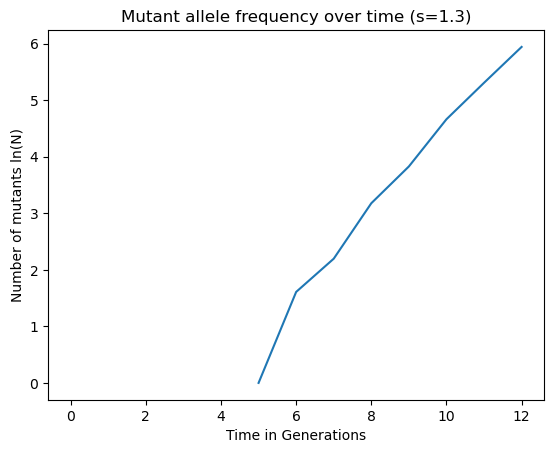

[{317: set()}, {}, {}, {}, {}, {317: set()}, {49: set(), 460: set(), 536: set(), 734: set(), 916: set()}, {9: set(), 226: set(), 338: set(), 406: set(), 414: set(), 476: set(), 549: set(), 663: set(), 704: set()}, {3: set(), 8: set(), 12: set(), 240: set(), 254: set(), 376: set(), 394: set(), 444: set(), 462: set(), 467: set(), 505: set(), 530: set(), 541: set(), 652: set(), 717: set(), 727: set(), 762: set(), 772: set(), 870: set(), 874: set(), 881: set(), 885: set(), 941: set(), 950: set()}, {10: set(), 30: set(), 38: set(), 44: set(), 46: set(), 94: set(), 101: set(), 104: set(), 118: set(), 125: set(), 182: set(), 215: set(), 230: set(), 258: set(), 278: set(), 344: set(), 364: set(), 367: set(), 375: set(), 392: set(), 451: set(), 470: set(), 471: set(), 486: set(), 501: set(), 536: set(), 613: set(), 618: set(), 625: set(), 647: set(), 651: set(), 676: set(), 734: set(), 766: set(), 768: set(), 788: set(), 793: set(), 844: set(), 865: set(), 866: set(), 879: set(), 895: set(), 91

IndexError: Cannot choose from an empty sequence

In [22]:
popul = Population(1000, 12, 5, 1.3) 
# go from population array to tree_clusters dictionary
gen, prob, mut, fig = popul.simulate_population()
tree_clusters = build_leaf_to_root_connections(gen, 6)

In [24]:
print(gen[12])

[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0
 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0
 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0
 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1
 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1
 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1
 0 1 1 1 0 0 1 0 1 0 1 0 

In [21]:
def build_leaf_to_root_connections(tree_mask, mut_samples):
    """
    Simulate the population using the Wright-Fisher model with selection.
    """
    # List of each generation, where each generation is a dict from node_idx to set of leaves
    node_to_leaves = []
    desired_number = mut_samples

    # Initialize the list of generations
    for generation_idx, generation in enumerate(tree_mask):
        node_to_leaves.append({})
        for node_idx, node in enumerate(generation):
            if node == 1:
                node_to_leaves[-1][node_idx] = set()

    assert desired_number <= len(node_to_leaves[-1])
    node_to_leaves[-1] = {
        id: set() 
        for id in np.random.choice(
            list(node_to_leaves[-1].keys()), 
            desired_number, 
            replace=False
        )
    }

    # Go backward from leaf to root, randomly assigning each leaf to a parent
    for leaf_idx in node_to_leaves[-1].keys():
        leaf_to_follow = None
        for generation_idx, generation in reversed(
            list(enumerate(node_to_leaves[:-1]))
        ):
            # If we already have a leaf to follow, pick it's ancestor, otherwise pick a random one
            if leaf_to_follow is not None:
                print("Leaf to follow is not None")
                parent_idx = next(
                    node
                    for node, leaves in generation.items()
                    if leaf_to_follow in leaves
                )
            else:
                # if len(generation.keys()) > 0:
                print("Random Parent Idx")
                parent_idx = random.choice(list(generation.keys()))
                
            # If the parent already has a leaf, pick it's ancestor in all previous generations to avoid cycles
            print(len(node_to_leaves[generation_idx][parent_idx]))
            if len(node_to_leaves[generation_idx][parent_idx]) > 0:
                leaf_to_follow = list(node_to_leaves[generation_idx][parent_idx])[0]

            # Add the leaf to the parent
            node_to_leaves[generation_idx][parent_idx].add(
                (len(node_to_leaves) - 1, leaf_idx)
            )

    # Drop any non leaves that weren't connected
    # Create a dict from node coordinates to leaf coordinates
    result = {}
    for generation_idx, generation in enumerate(node_to_leaves):
        for node_idx, leaves in generation.items():
            if generation_idx == len(node_to_leaves) - 1 or len(leaves) > 0:
                result[str((generation_idx, node_idx))] = {str(leaf) for leaf in leaves}

    return result